# Convert OpenGWAS Project vcf file to PLINK GWAS formats  

Type 2 Diabetes GWAS data downloaded from OpenGWAS Project:  
https://gwas.mrcieu.ac.uk/datasets/ieu-a-25/ 

#### Imports & Setup

In [1]:
import pandas as pd
import io

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### File I/O variables

In [2]:
## input file
vcf_file = '../data/gwas_vcf/ieu-a-25.vcf'

## output files
assoc_out = '../data/gwas_plink/ieu-a-25_v2.assoc'
logistic_out = '../data/gwas_plink/ieu-a-25_v2.assoc.logistic'
vcf_out = '../data/gwas_plink/ieu-a-25_v2.vcf.extracted.gwas'

### Read in VCF file  

In [3]:
!grep "##FORMAT="  {vcf_file}

##FORMAT=<ID=ES,Number=A,Type=Float,Description="Effect size estimate relative to the alternative allele">
##FORMAT=<ID=SE,Number=A,Type=Float,Description="Standard error of effect size estimate">
##FORMAT=<ID=LP,Number=A,Type=Float,Description="-log10 p-value for effect estimate">
##FORMAT=<ID=AF,Number=A,Type=Float,Description="Alternate allele frequency in the association study">
##FORMAT=<ID=SS,Number=A,Type=Float,Description="Sample size used to estimate genetic effect">
##FORMAT=<ID=EZ,Number=A,Type=Float,Description="Z-score provided if it was used to derive the EFFECT and SE fields">
##FORMAT=<ID=SI,Number=A,Type=Float,Description="Accuracy score of summary data imputation">
##FORMAT=<ID=NC,Number=A,Type=Float,Description="Number of cases used to estimate genetic effect">
##FORMAT=<ID=ID,Number=1,Type=String,Description="Study variant identifier">


In [4]:
!awk 'NR >= 110 && NR <= 115'  {vcf_file}

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	ieu-a-25
1	120437718	rs2793823	G	A	.	PASS	AF=0.132	ES:SE:LP:AF:SS:ID	0.0592119:0.0185129:2.85387:0.132:73902.3:rs2793823
1	120437884	rs2641348	A	G	.	PASS	AF=0.11	ES:SE:LP:AF:SS:ID	0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348
1	120438577	rs147294252	G	A	.	PASS	AF=0.006	ES:SE:LP:AF:SS:ID	0.123986:0.108496:0.60206:0.006:67530.5:rs147294252
1	120439109	rs6668119	G	C	.	PASS	AF=0.106	ES:SE:LP:AF:SS:ID	0.0685928:0.0202474:3.13668:0.106:73902.3:rs6668119
1	120440029	rs2027447	T	C	.	PASS	AF=0.11	ES:SE:LP:AF:SS:ID	0.0676586:0.0200183:3.16749:0.11:73902.3:rs2027447


#### read vcf file using Python functions

In [5]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})


def read_header(path):
    with open(path, 'r') as f:
        header = [l for l in f if l.startswith('##')]
    return header

In [6]:
vcf_in = read_vcf(vcf_file)

vcf_in.shape
vcf_in.head()

(42089, 10)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   
3     1  120439109    rs6668119   G   C    .   PASS  AF=0.106   
4     1  120440029    rs2027447   T   C    .   PASS   AF=0.11   

              FORMAT                                           ieu-a-25  
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...  
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348  
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...  
3  ES:SE:LP:AF:SS:ID  0.0685928:0.0202474:3.13668:0.106:73902.3:rs66...  
4  ES:SE:LP:AF:SS:ID  0.0676586:0.0200183:3.16749:0.11:73902.3:rs202...

In [7]:
vcf_in['CHROM'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '15', '16', '17', '18', '19', '20'], dtype=object)

In [8]:
cols_input = vcf_in.columns.to_list()
cols_input

['CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'QUAL',
 'FILTER',
 'INFO',
 'FORMAT',
 'ieu-a-25']

In [9]:
cols_input[-1]

'ieu-a-25'

### Extract vcf format fields --> separate columns

Extract format field names from 'FORMAT' column

In [10]:
_fmt_str = vcf_in.loc[0, 'FORMAT']
_fmt_str

_fmt_list = _fmt_str.split(':')
_fmt_list

'ES:SE:LP:AF:SS:ID'

['ES', 'SE', 'LP', 'AF', 'SS', 'ID']

Test splitting format column - strange results in output file

In [11]:
_test_split = vcf_in[cols_input[-1]].str.split(':', expand=True)

_test_split.shape
_test_split.head()
_test_split.tail()

(42089, 6)

0          1        2      3        4            5
0  0.0592119  0.0185129  2.85387  0.132  73902.3    rs2793823
1   0.064851  0.0200746  2.95861   0.11  73902.3    rs2641348
2   0.123986   0.108496  0.60206  0.006  67530.5  rs147294252
3  0.0685928  0.0202474  3.13668  0.106  73902.3    rs6668119
4  0.0676586  0.0200183  3.16749   0.11  73902.3    rs2027447

0          1          2      3        4            5
42084  -0.0009995  0.0129935  0.0222764  0.611  73902.3    rs6031601
42085   -0.361165   0.174686    1.40894  0.003  61574.2  rs112600410
42086  -0.0207825   0.024981   0.387216  0.069  73902.3   rs74173201
42087  0.00399202  0.0127069   0.124939  0.517  73901.3    rs3746574
42088  -0.0009995  0.0129935  0.0362122  0.607  73901.4    rs3746575

In [12]:
_test_split.columns = _fmt_list

_test_split.head()

ES         SE       LP     AF       SS           ID
0  0.0592119  0.0185129  2.85387  0.132  73902.3    rs2793823
1   0.064851  0.0200746  2.95861   0.11  73902.3    rs2641348
2   0.123986   0.108496  0.60206  0.006  67530.5  rs147294252
3  0.0685928  0.0202474  3.13668  0.106  73902.3    rs6668119
4  0.0676586  0.0200183  3.16749   0.11  73902.3    rs2027447

In [13]:
_test_split[_test_split['ID'].isnull()]

ES        SE          LP       AF           SS    ID
4998    -0.330023  0.366755    0.431798  60983.4    rs7561403  None
5065    -0.178146  0.318898    0.236572  62776.7   rs17030796  None
5087    -0.213497  0.330482    0.283997  61699.3    rs7583188  None
5088    -0.215111  0.330304    0.283997  61699.3    rs7609383  None
5264     0.491643  0.404218    0.657577  61094.3  rs116687196  None
5445    -0.172271   0.31419    0.236572  60983.4   rs79083585  None
5446    -0.173113  0.314306    0.236572  60983.4   rs76000447  None
5658    0.0198026  0.332407   0.0222764  61550.7   rs17031084  None
9202     0.142367  0.344691    0.167491  67294.2  rs191603721  None
12340  0.00299551  0.347162  0.00436481  59158.4  rs149147187  None
13341   -0.076961  0.322863    0.091515  59484.8  rs115230684  None
13568  -0.0227395  0.330105   0.0268721  59341.3  rs140756342  None
15325     0.64658   0.35565     1.16115  61020.2   rs77317587  None
17610   -0.206201  0.406486     0.21467  61582.6   rs75134687  None
20407  -0.0870947  0.383914   0.0861861  60104.9   rs75979662  None
21261    0.352767  0.346026    0.508638  59719.9  rs141492493  None
21869    -0.27079  0.351798    0.356547  59400.9   rs73643725  None
22937    0.387301  0.377448    0.508638  60734.8  rs116519240  None
24141  0.00498754  0.341082  0.00436481  60060.9   rs10882080  None
24165   -0.116894  0.333227    0.136677  62508.7   rs11187068  None
24244    0.496524  0.350852     0.79588    59621    rs7069538  None
24695   -0.334327  0.324267    0.522879  60469.9    rs2497317  None
24847   0.0916672  0.425658   0.0809219    61484   rs56372770  None
25086    0.143234  0.327025    0.180456  60009.9  rs114140435  None
25356    0.414094  0.414719     0.49485  63209.9   rs16928333  None
33911     -0.1415  0.335267    0.173925  59259.6   rs74520776  None
34132  -0.0620354   0.38505   0.0604807  60304.3   rs74019306  None
35274   -0.220741  0.386972    0.244125  62748.1  rs185523278  None
38664  -0.0778865  0.353529   0.0809219  59991.8   rs17066796  None
38695  -0.0657877  0.362011   0.0655015  59991.9   rs75861317  None
40847    -0.19062  0.371974     0.21467  62534.9  rs140011687  None

#### strange - variable # of values in FORMAT column post split --> examine FORMAT values?

In [14]:
_format_vals = vcf_in['FORMAT'].unique().tolist()

_format_vals

['ES:SE:LP:AF:SS:ID', 'ES:SE:LP:SS:ID']

#### add cols before splitting FORMAT column

In [15]:
vcf_in['idx'] = vcf_in.index.copy()
vcf_in['CHR'] = vcf_in['CHROM'].copy()
vcf_in['BP'] = vcf_in['POS'].copy()
vcf_in['A1'] = vcf_in['ALT'].copy()
vcf_in['A2'] = vcf_in['REF'].copy()

Split DF by FORMAT colum

In [16]:
_vcf_in_a = vcf_in[vcf_in['FORMAT']== _format_vals[0]].copy()

_vcf_in_b = vcf_in[vcf_in['FORMAT']== _format_vals[1]].copy()

_vcf_in_b.shape

(31, 15)

### Split sample column --> format fields

In [17]:
# vcf_in[_fmt_list] = vcf_in[cols_input[-1]].str.split(':', expand=True)

# vcf_in.head()

In [18]:
_vcf_in_a[_format_vals[0].split(':')] = _vcf_in_a[cols_input[-1]].str.split(':', expand=True)

vcf_in.shape
_vcf_in_a.shape
_vcf_in_a.head()

(42089, 15)

(42058, 20)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   
3     1  120439109    rs6668119   G   C    .   PASS  AF=0.106   
4     1  120440029    rs2027447   T   C    .   PASS   AF=0.11   

              FORMAT                                           ieu-a-25  idx  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...    0   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348    1   
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...    2   
3  ES:SE:LP:AF:SS:ID  0.0685928:0.0202474:3.13668:0.106:73902.3:rs66...    3   
4  ES:SE:LP:AF:SS:ID  0.0676586:0.0200183:3.16749:0.11:73902.3:rs202...    4   

  CHR         BP A1 A2         ES         SE       LP     AF       SS  
0   1  120437718  A  G  0.0592119  0.0185129  2.85387  0.132  73902.3  
1   1  120437884  G  A   0.064851  0.0200746  2.95861   0.11  73902.3  
2   1  120438577  A  G   0.123986   0.108496  0.60206  0.006  67530.5  
3   1  120439109  C  G  0.0685928  0.0202474  3.13668  0.106  73902.3  
4   1  120440029  C  T  0.0676586  0.0200183  3.16749   0.11  73902.3

In [21]:
_vcf_in_b[_format_vals[1].split(':')] = _vcf_in_b[cols_input[-1]].str.split(':', expand=True)

vcf_in.shape
_vcf_in_b.shape

vcf_in.head(2)
_vcf_in_b.head()

vcf_in.columns
_vcf_in_b.columns

(42089, 15)

(31, 19)

CHROM        POS         ID REF ALT QUAL FILTER      INFO  \
0     1  120437718  rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884  rs2641348   A   G    .   PASS   AF=0.11   

              FORMAT                                           ieu-a-25  idx  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...    0   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348    1   

  CHR         BP A1 A2  
0   1  120437718  A  G  
1   1  120437884  G  A

CHROM       POS           ID REF ALT QUAL FILTER INFO          FORMAT  \
4998     2  43654289    rs7561403   A   G    .   PASS    .  ES:SE:LP:SS:ID   
5065     2  43668719   rs17030796   A   C    .   PASS    .  ES:SE:LP:SS:ID   
5087     2  43672596    rs7583188   G   T    .   PASS    .  ES:SE:LP:SS:ID   
5088     2  43672597    rs7609383   A   C    .   PASS    .  ES:SE:LP:SS:ID   
5264     2  43715466  rs116687196   G   A    .   PASS    .  ES:SE:LP:SS:ID   

                                            ieu-a-25   idx CHR        BP A1  \
4998   -0.330023:0.366755:0.431798:60983.4:rs7561403  4998   2  43654289  G   
5065  -0.178146:0.318898:0.236572:62776.7:rs17030796  5065   2  43668719  C   
5087   -0.213497:0.330482:0.283997:61699.3:rs7583188  5087   2  43672596  T   
5088   -0.215111:0.330304:0.283997:61699.3:rs7609383  5088   2  43672597  C   
5264  0.491643:0.404218:0.657577:61094.3:rs116687196  5264   2  43715466  A   

     A2         ES        SE        LP       SS  
4998  A  -0.330023  0.366755  0.431798  60983.4  
5065  A  -0.178146  0.318898  0.236572  62776.7  
5087  G  -0.213497  0.330482  0.283997  61699.3  
5088  A  -0.215111  0.330304  0.283997  61699.3  
5264  G   0.491643  0.404218  0.657577  61094.3

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'ieu-a-25', 'idx', 'CHR', 'BP', 'A1', 'A2'],
      dtype='object')

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'ieu-a-25', 'idx', 'CHR', 'BP', 'A1', 'A2', 'ES', 'SE', 'LP', 'SS'],
      dtype='object')

In [23]:
vcf_in2 = pd.concat([_vcf_in_a, _vcf_in_b], axis=0)


vcf_in.shape
vcf_in2.shape

vcf_in2.tail()

vcf_in2['AF'] = vcf_in2['AF'].fillna(0.0)

vcf_in2.tail()

vcf_in2 = vcf_in2.sort_values('idx').reset_index(drop=True)
vcf_in2.tail()

(42089, 15)

(42089, 20)

CHROM       POS           ID REF ALT QUAL FILTER INFO          FORMAT  \
34132    15  62439584   rs74019306   T   C    .   PASS    .  ES:SE:LP:SS:ID   
35274    16  53595556  rs185523278   T   C    .   PASS    .  ES:SE:LP:SS:ID   
38664    18  57984175   rs17066796   T   C    .   PASS    .  ES:SE:LP:SS:ID   
38695    18  57992859   rs75861317   T   A    .   PASS    .  ES:SE:LP:SS:ID   
40847    19  19783572  rs140011687   G   A    .   PASS    .  ES:SE:LP:SS:ID   

                                               ieu-a-25    idx CHR        BP  \
34132   -0.0620354:0.38505:0.0604807:60304.3:rs74019306  34132  15  62439584   
35274   -0.220741:0.386972:0.244125:62748.1:rs185523278  35274  16  53595556   
38664  -0.0778865:0.353529:0.0809219:59991.8:rs17066796  38664  18  57984175   
38695  -0.0657877:0.362011:0.0655015:59991.9:rs75861317  38695  18  57992859   
40847     -0.19062:0.371974:0.21467:62534.9:rs140011687  40847  19  19783572   

      A1 A2          ES        SE         LP   AF       SS  
34132  C  T  -0.0620354   0.38505  0.0604807  NaN  60304.3  
35274  C  T   -0.220741  0.386972   0.244125  NaN  62748.1  
38664  C  T  -0.0778865  0.353529  0.0809219  NaN  59991.8  
38695  A  T  -0.0657877  0.362011  0.0655015  NaN  59991.9  
40847  A  G    -0.19062  0.371974    0.21467  NaN  62534.9

CHROM       POS           ID REF ALT QUAL FILTER INFO          FORMAT  \
34132    15  62439584   rs74019306   T   C    .   PASS    .  ES:SE:LP:SS:ID   
35274    16  53595556  rs185523278   T   C    .   PASS    .  ES:SE:LP:SS:ID   
38664    18  57984175   rs17066796   T   C    .   PASS    .  ES:SE:LP:SS:ID   
38695    18  57992859   rs75861317   T   A    .   PASS    .  ES:SE:LP:SS:ID   
40847    19  19783572  rs140011687   G   A    .   PASS    .  ES:SE:LP:SS:ID   

                                               ieu-a-25    idx CHR        BP  \
34132   -0.0620354:0.38505:0.0604807:60304.3:rs74019306  34132  15  62439584   
35274   -0.220741:0.386972:0.244125:62748.1:rs185523278  35274  16  53595556   
38664  -0.0778865:0.353529:0.0809219:59991.8:rs17066796  38664  18  57984175   
38695  -0.0657877:0.362011:0.0655015:59991.9:rs75861317  38695  18  57992859   
40847     -0.19062:0.371974:0.21467:62534.9:rs140011687  40847  19  19783572   

      A1 A2          ES        SE         LP   AF       SS  
34132  C  T  -0.0620354   0.38505  0.0604807  0.0  60304.3  
35274  C  T   -0.220741  0.386972   0.244125  0.0  62748.1  
38664  C  T  -0.0778865  0.353529  0.0809219  0.0  59991.8  
38695  A  T  -0.0657877  0.362011  0.0655015  0.0  59991.9  
40847  A  G    -0.19062  0.371974    0.21467  0.0  62534.9

CHROM       POS           ID REF ALT QUAL FILTER      INFO  \
42084    20  43057820    rs6031601   C   A    .   PASS  AF=0.611   
42085    20  43057831  rs112600410   A   G    .   PASS  AF=0.003   
42086    20  43058012   rs74173201   A   C    .   PASS  AF=0.069   
42087    20  43058018    rs3746574   T   C    .   PASS  AF=0.517   
42088    20  43058096    rs3746575   C   G    .   PASS  AF=0.607   

                  FORMAT                                           ieu-a-25  \
42084  ES:SE:LP:AF:SS:ID  -0.0009995:0.0129935:0.0222764:0.611:73902.3:r...   
42085  ES:SE:LP:AF:SS:ID  -0.361165:0.174686:1.40894:0.003:61574.2:rs112...   
42086  ES:SE:LP:AF:SS:ID  -0.0207825:0.024981:0.387216:0.069:73902.3:rs7...   
42087  ES:SE:LP:AF:SS:ID  0.00399202:0.0127069:0.124939:0.517:73901.3:rs...   
42088  ES:SE:LP:AF:SS:ID  -0.0009995:0.0129935:0.0362122:0.607:73901.4:r...   

         idx CHR        BP A1 A2          ES         SE         LP     AF  \
42084  42084  20  43057820  A  C  -0.0009995  0.0129935  0.0222764  0.611   
42085  42085  20  43057831  G  A   -0.361165   0.174686    1.40894  0.003   
42086  42086  20  43058012  C  A  -0.0207825   0.024981   0.387216  0.069   
42087  42087  20  43058018  C  T  0.00399202  0.0127069   0.124939  0.517   
42088  42088  20  43058096  G  C  -0.0009995  0.0129935  0.0362122  0.607   

            SS  
42084  73902.3  
42085  61574.2  
42086  73902.3  
42087  73901.3  
42088  73901.4

<br>  

<br>  

# Convert extracted vcf DF to PLINK format

https://www.cog-genomics.org/plink/1.9/formats#assoc



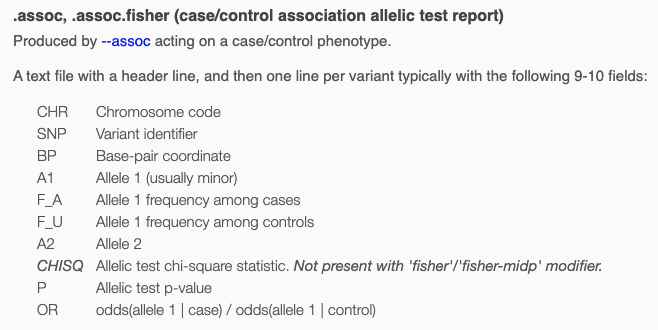  

https://www.cog-genomics.org/plink/1.9/formats#assoc_linear  


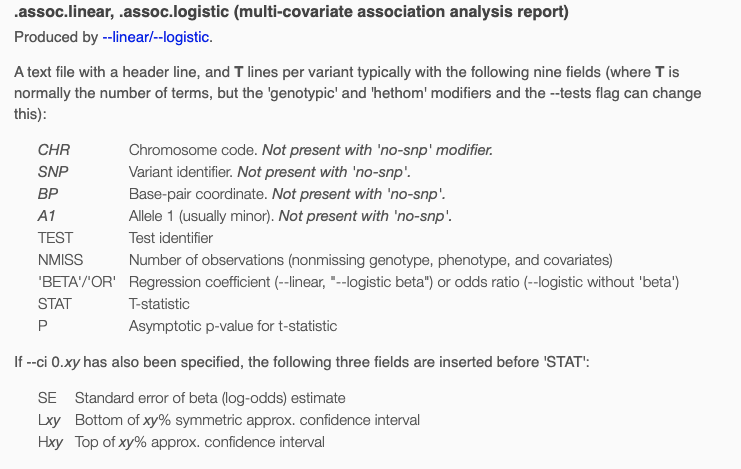  



**add renamed columns:**  
* A1 = Alt Allele (PLINK A1 allele is usually but not always Alt allele)  
* A2 = Ref Allele  
* BP = POS  
* OR = ES = effect size  
* NMISS = .logistic number of observations (nonmissing genotype, phenotype, & covar)

**add columns with "dummy" values:**  
* F_A = .assoc AF affected  
* F_U = .assoc AF unaffected  
* CHISQ = .assoc ChiSquare  
* TEST = .logistic statistical test (set to ADD for additive model)    
* STAT = .logistic t-statistic  


**convert vcf columns to plink columns:**  

* SNP from CHR + BP  
* P from LP (LP = -log10 P) --> 10^-LP  


In [24]:
cols_assoc = ['CHR', 'SNP', 'BP', 'A1', 'F_A', 'F_U', 'A2', 'CHISQ', 'P', 'OR']
cols_logistic = ['CHR', 'SNP', 'BP', 'A1', 'TEST', 'NMISS', 'OR', 'SE', 'STAT', 'P']

In [25]:
# df = vcf_in.copy() 

df = vcf_in2.copy() 

In [26]:
df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'ieu-a-25', 'idx', 'CHR', 'BP', 'A1', 'A2', 'ES', 'SE', 'LP', 'AF',
       'SS'],
      dtype='object')

#### 1) add renamed columns:  

* A1 = Alt Allele (PLINK A1 allele is usually but not always Alt allele)  
* A2 = Ref Allele  
* BP = POS  
* OR = ES = effect size  
* NMISS = SS = sample size (approx, not quite the number of observations)

In [27]:
# df['CHR'] = df['CHROM'].copy()
# df['BP'] = df['POS'].copy()
# df['A1'] = df['ALT'].copy()
# df['A2'] = df['REF'].copy()
df['OR'] = df['ES'].copy()
df['NMISS'] = df['SS'].copy()

df.head(3)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   

              FORMAT                                           ieu-a-25  ...  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...  ...   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348  ...   
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...  ...   

          BP A1  A2         ES         SE       LP     AF       SS         OR  \
0  120437718  A   G  0.0592119  0.0185129  2.85387  0.132  73902.3  0.0592119   
1  120437884  G   A   0.064851  0.0200746  2.95861   0.11  73902.3   0.064851   
2  120438577  A   G   0.123986   0.108496  0.60206  0.006  67530.5   0.123986   

     NMISS  
0  73902.3  
1  73902.3  
2  67530.5  

[3 rows x 22 columns]

In [28]:
df['CHROM'].unique()
df['CHR'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '15', '16', '17', '18', '19', '20'], dtype=object)

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '15', '16', '17', '18', '19', '20'], dtype=object)

#### 2) add columns with "dummy" values:  

* F_A = .assoc AF affected  
* F_U = .assoc AF unaffected  
* CHISQ = .assoc ChiSquare  
* TEST = .logistic statistical test (set to ADD for additive model)  
* STAT = .logistic t-statistic  


In [29]:
df['F_A'] = 0.0 
df['F_U'] = 0.0 
df['CHISQ'] = 0.0 
df['TEST'] = 'ADD' 
df['STAT'] = 0.0 

df.head(3)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   

              FORMAT                                           ieu-a-25  ...  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...  ...   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348  ...   
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...  ...   

        LP     AF       SS         OR    NMISS  F_A  F_U CHISQ TEST STAT  
0  2.85387  0.132  73902.3  0.0592119  73902.3  0.0  0.0   0.0  ADD  0.0  
1  2.95861   0.11  73902.3   0.064851  73902.3  0.0  0.0   0.0  ADD  0.0  
2  0.60206  0.006  67530.5   0.123986  67530.5  0.0  0.0   0.0  ADD  0.0  

[3 rows x 27 columns]

#### 3) convert vcf columns to plink columns:    

* SNP from CHR + BP  
* P from LP (LP = -log10 P) --> 10^-LP  

In [30]:
df['SNP'] = df['CHROM'].astype(str) + '_' + df['POS'].astype(str) + '_' + df['ID'].astype(str) 

df.head(3)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   

              FORMAT                                           ieu-a-25  ...  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...  ...   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348  ...   
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...  ...   

      AF       SS         OR    NMISS  F_A  F_U CHISQ TEST STAT  \
0  0.132  73902.3  0.0592119  73902.3  0.0  0.0   0.0  ADD  0.0   
1   0.11  73902.3   0.064851  73902.3  0.0  0.0   0.0  ADD  0.0   
2  0.006  67530.5   0.123986  67530.5  0.0  0.0   0.0  ADD  0.0   

                       SNP  
0    1_120437718_rs2793823  
1    1_120437884_rs2641348  
2  1_120438577_rs147294252  

[3 rows x 28 columns]

In [31]:
df['LP'] = df['LP'].astype(float)

df['P'] = pow(10, -df['LP'])

df.head(3)

CHROM        POS           ID REF ALT QUAL FILTER      INFO  \
0     1  120437718    rs2793823   G   A    .   PASS  AF=0.132   
1     1  120437884    rs2641348   A   G    .   PASS   AF=0.11   
2     1  120438577  rs147294252   G   A    .   PASS  AF=0.006   

              FORMAT                                           ieu-a-25  ...  \
0  ES:SE:LP:AF:SS:ID  0.0592119:0.0185129:2.85387:0.132:73902.3:rs27...  ...   
1  ES:SE:LP:AF:SS:ID  0.064851:0.0200746:2.95861:0.11:73902.3:rs2641348  ...   
2  ES:SE:LP:AF:SS:ID  0.123986:0.108496:0.60206:0.006:67530.5:rs1472...  ...   

        SS         OR    NMISS  F_A  F_U CHISQ TEST  STAT  \
0  73902.3  0.0592119  73902.3  0.0  0.0   0.0  ADD   0.0   
1  73902.3   0.064851  73902.3  0.0  0.0   0.0  ADD   0.0   
2  67530.5   0.123986  67530.5  0.0  0.0   0.0  ADD   0.0   

                       SNP       P  
0    1_120437718_rs2793823  0.0014  
1    1_120437884_rs2641348  0.0011  
2  1_120438577_rs147294252  0.2500  

[3 rows x 29 columns]

In [32]:
df[['LP', 'P']].head(10)

LP        P
0  2.853870  0.00140
1  2.958610  0.00110
2  0.602060  0.25000
3  3.136680  0.00073
4  3.167490  0.00068
5  0.060481  0.87000
6  2.920820  0.00120
7  1.795880  0.01600
8  0.259637  0.55000
9  3.075720  0.00084

In [33]:
df[df['P'].isnull()]


Empty DataFrame
Columns: [CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, ieu-a-25, idx, CHR, BP, A1, A2, ES, SE, LP, AF, SS, OR, NMISS, F_A, F_U, CHISQ, TEST, STAT, SNP, P]
Index: []

[0 rows x 29 columns]

<br>  

## Extract columns for .assoc + .logistic output files

In [34]:
df_assoc = df[cols_assoc]
df_logistic = df[cols_logistic]

df_assoc.shape
df_logistic.shape
df.shape

(42089, 10)

(42089, 10)

(42089, 29)

In [35]:
df_assoc.head(2)
df_logistic.head(2)

CHR                    SNP         BP A1  F_A  F_U A2  CHISQ       P  \
0   1  1_120437718_rs2793823  120437718  A  0.0  0.0  G    0.0  0.0014   
1   1  1_120437884_rs2641348  120437884  G  0.0  0.0  A    0.0  0.0011   

          OR  
0  0.0592119  
1   0.064851

CHR                    SNP         BP A1 TEST    NMISS         OR  \
0   1  1_120437718_rs2793823  120437718  A  ADD  73902.3  0.0592119   
1   1  1_120437884_rs2641348  120437884  G  ADD  73902.3   0.064851   

          SE  STAT       P  
0  0.0185129   0.0  0.0014  
1  0.0200746   0.0  0.0011

### write output files

In [36]:
df_assoc.to_csv(assoc_out, header=True, index=False, sep=' ')
df_logistic.to_csv(logistic_out, header=True, index=False, sep=' ')

In [37]:
df.to_csv(vcf_out, header=True, index=False, sep='\t')